In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import csv
import scipy.stats
plt.style.use('seaborn-whitegrid')

In [2]:
def darllen_tim(cymhareb, ych):
    tim = []
    pmoves = {}
    if ych:
        enw = f'timau/tim_ychwanegol_={cymhareb}.csv'
    else:
        enw = f'timau/tim_={cymhareb}.csv'
    with open(enw, 'r') as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            tim.append(int(row[0]))
            pmoves[int(row[0])] = [int(r) for r in row[1:]]
    return tim, pmoves

In [3]:
with open('params/max_f1.csv', 'r') as f:
    maxf1 = float(f.read())
with open('params/max_f2.csv', 'r') as f:
    maxf2 = float(f.read())
with open('params/max_f1_ych.csv', 'r') as f:
    maxf1_ych = float(f.read())
with open('params/max_f2_ych.csv', 'r') as f:
    maxf2_ych = float(f.read())

In [4]:
def cyfanswm_stats(row):
    if row['Special Attacker']:
        return row['HP'] + row['SpAttack'] + row['Defense'] + row['SpDefense'] + row['Speed']
    return row['HP'] + row['Attack'] + row['Defense'] + row['SpDefense'] + row['Speed']

In [5]:
pdata = pd.read_csv('data/pdata_base.csv', index_col=0)
mdata = pd.read_csv('data/allowed_moves.csv', index_col=0)
learnset = pd.read_csv('data/learnset_base.csv', index_col=0)

In [6]:
pdata['Special Attacker'] = (pdata['Attack'] <= pdata['SpAttack']).astype(int)
pdata['Physical Attacker'] = (pdata['SpAttack'] <= pdata['Attack']).astype(int)
pdata['TotalStats'] = pdata.apply(cyfanswm_stats, axis=1)
stab = {p: {a: int(mdata.loc[a, 'Type'] in [pdata.loc[p, 'Type1'], pdata.loc[p, 'Type2']]) for a in mdata.index} for p in pdata.index}

In [7]:
def f1(tim):
    return (sum(pdata.loc[p, 'TotalStats'] for p in tim))

In [8]:
def f2(tim, pmoves):
    return sum((1 + (0.5 * stab[p][a])) * mdata.loc[a, 'Power'] * mdata.loc[a, 'Accuracy'] for p in tim for a in pmoves[p])

In [9]:
cymarebau = [round(i * 0.01, 5) for i in range(101)]

In [10]:
sgoriau = []
f1s = []
f2s = []
for cymhareb in cymarebau:
    with open(f'canlyniadau/tim_={cymhareb}.csv', 'r') as f:
        s = float(f.read())
        sgoriau.append(s)
    tim, pmoves = darllen_tim(cymhareb, ych=False)
    f1s.append(f1(tim))
    f2s.append(f2(tim, pmoves))

In [11]:
hapsgoriau = []
for i in range(100):
    with open(f'canlyniadau/haptim_{i}.csv', 'r') as f:
        s = float(f.read())
        hapsgoriau.append(s)

In [12]:
upper = [p + (scipy.stats.norm(loc=0, scale=1).ppf(0.9)/2) * ((p*(1-p))/10000)**0.5 for p in sgoriau]
lower = [p - (scipy.stats.norm(loc=0, scale=1).ppf(0.9)/2) * ((p*(1-p))/10000)**0.5 for p in sgoriau]

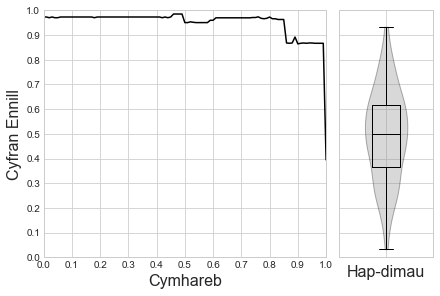

In [13]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAAB
    """
)
# axd['A'].fill_between(cymarebau, lower, upper, color='gray', alpha=0.5)
axd['A'].plot(cymarebau, sgoriau, c='black')
axd['A'].set_xlabel('Cymhareb', fontsize=16)
axd['A'].set_ylabel('Cyfran Ennill', fontsize=16)
axd['A'].set_xlim(0, 1)
axd['A'].set_ylim(0, 1)
axd['A'].set_xticks([round(i*0.1, 2) for i in range(11)])
axd['A'].set_yticks([round(i*0.1, 2) for i in range(11)])
viols = axd['B'].violinplot(hapsgoriau, showextrema=False, widths=0.45)
for pc in viols['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(0.3)
boxes = axd['B'].boxplot(hapsgoriau, medianprops = dict(color="black"), widths=0.3)
axd['B'].set_ylim(0, 1)
axd['B'].set_yticks([round(i*0.1, 2) for i in range(11)])
axd['B'].set_yticklabels([])
axd['B'].set_xticklabels([])
axd['B'].set_xlabel('Hap-dimau', fontsize=16)

plt.savefig('img/cymharu_pareto.pdf')

In [14]:
pareto_approx = []
for coord in zip(f1s, f2s):
    if len(pareto_approx) == 0:
        pareto_approx.append(coord)
    elif coord != pareto_approx[-1]:
        pareto_approx.append(coord)
pareto_approx_x = [pareto_approx[0][0] / maxf1 * 0.99] + [coord[0]/maxf1 for coord in pareto_approx]
pareto_approx_y = [pareto_approx[0][1] / maxf2] + [coord[1]/maxf2 for coord in pareto_approx]

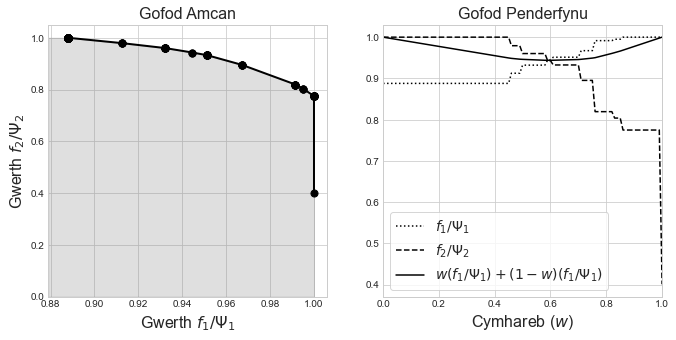

In [15]:
fig, axarr = plt.subplots(1, 2, figsize=(11, 5))
axarr[0].fill_between(pareto_approx_x, [0 for _ in pareto_approx_x], pareto_approx_y, color='gray', alpha=0.25)
axarr[0].plot(pareto_approx_x[1:], pareto_approx_y[1:], c='black', linewidth=2)
axarr[0].scatter([f/maxf1 for f in f1s], [f/maxf2 for f in f2s], s=50, color='black')
axarr[0].set_xlabel(r'Gwerth $f_1 / \Psi_1$', fontsize=16)
axarr[0].set_ylabel(r'Gwerth $f_2 / \Psi_2$', fontsize=16)
axarr[0].ticklabel_format(axis="y", style='sci', scilimits=(0,0))
axarr[0].set_xlim(left=pareto_approx_x[0])
axarr[0].set_ylim(bottom=0)
axarr[0].set_title("Gofod Amcan", fontsize=16)

axarr[1].plot(cymarebau, [f1/maxf1 for f1 in f1s], c='black', linestyle='dotted', label=r"$f_1 / \Psi_1$")
axarr[1].plot(cymarebau, [f2/maxf2 for f2 in f2s], c='black', linestyle='dashed', label=r"$f_2 / \Psi_2$")
axarr[1].plot(cymarebau, [(c*(f1/maxf1))+((1 - c)*(f2/maxf2)) for c, f1, f2 in zip(cymarebau, f1s, f2s)], c='black', linestyle='solid', label=r"$w(f_1 / \Psi_1) + (1 - w)(f_1 / \Psi_1)$")
axarr[1].legend(fontsize=14, frameon=True)
axarr[1].set_xlim(0, 1)
axarr[1].set_xlabel(r'Cymhareb ($w$)', fontsize=16)
axarr[1].set_title("Gofod Penderfynu", fontsize=16)
plt.savefig('img/ffrynt_pareto.pdf')

In [16]:
[cymarebau[i] for i in range(51) if sgoriau[i] == max(sgoriau)]

[0.46, 0.47, 0.48, 0.49]

In [17]:
sgoriau_ych = []
f1s_ych = []
f2s_ych = []
for cymhareb in cymarebau:
    with open(f'canlyniadau/tim_ychwanegol_={cymhareb}.csv', 'r') as f:
        s = float(f.read())
        sgoriau_ych.append(s)
    tim, pmoves = darllen_tim(cymhareb, ych=True)
    f1s_ych.append(f1(tim))
    f2s_ych.append(f2(tim, pmoves))

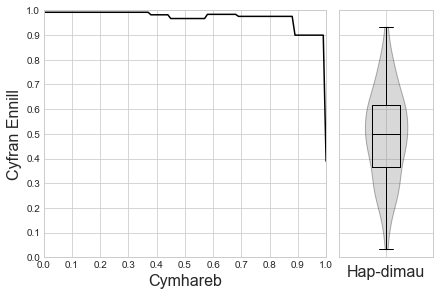

In [18]:
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAAB
    """
)
axd['A'].plot(cymarebau, sgoriau_ych, c='black')
axd['A'].set_xlabel('Cymhareb', fontsize=16)
axd['A'].set_ylabel('Cyfran Ennill', fontsize=16)
axd['A'].set_xlim(0, 1)
axd['A'].set_ylim(0, 1)
axd['A'].set_xticks([round(i*0.1, 2) for i in range(11)])
axd['A'].set_yticks([round(i*0.1, 2) for i in range(11)])
viols = axd['B'].violinplot(hapsgoriau, showextrema=False, widths=0.45)
for pc in viols['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(0.3)
boxes = axd['B'].boxplot(hapsgoriau, medianprops = dict(color="black"), widths=0.3)
axd['B'].set_ylim(0, 1)
axd['B'].set_yticks([round(i*0.1, 2) for i in range(11)])
axd['B'].set_yticklabels([])
axd['B'].set_xticklabels([])
axd['B'].set_xlabel('Hap-dimau', fontsize=16)

plt.savefig('img/cymharu_pareto_ychwanegol.pdf')

In [19]:
pareto_approx_ych = []
for coord in zip(f1s_ych, f2s_ych):
    if len(pareto_approx_ych) == 0:
        pareto_approx_ych.append(coord)
    elif coord != pareto_approx_ych[-1]:
        pareto_approx_ych.append(coord)
pareto_approx_ych_x = [pareto_approx_ych[0][0] / maxf1_ych * 0.99] + [coord[0]/maxf1_ych for coord in pareto_approx_ych]
pareto_approx_ych_y = [pareto_approx_ych[0][1] / maxf2_ych] + [coord[1]/maxf2_ych for coord in pareto_approx_ych]

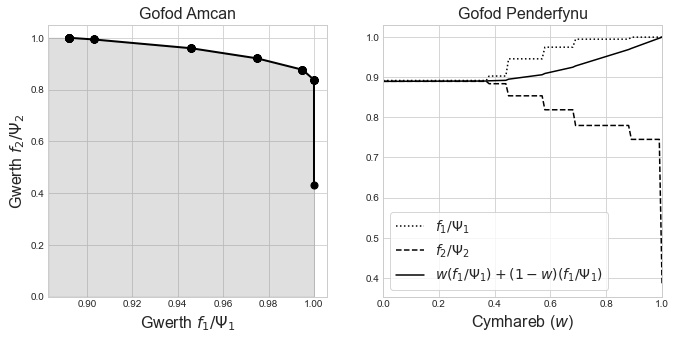

In [20]:
fig, axarr = plt.subplots(1, 2, figsize=(11, 5))
axarr[0].fill_between(pareto_approx_ych_x, [0 for _ in pareto_approx_ych_x], pareto_approx_ych_y, color='gray', alpha=0.25)
axarr[0].plot(pareto_approx_ych_x[1:], pareto_approx_ych_y[1:], c='black', linewidth=2)
axarr[0].scatter([f/maxf1_ych for f in f1s_ych], [f/maxf2_ych for f in f2s_ych], s=50, color='black')
axarr[0].set_xlabel(r'Gwerth $f_1 / \Psi_1$', fontsize=16)
axarr[0].set_ylabel(r'Gwerth $f_2 / \Psi_2$', fontsize=16)
axarr[0].ticklabel_format(axis="y", style='sci', scilimits=(0,0))
axarr[0].set_xlim(left=pareto_approx_ych_x[0])
axarr[0].set_ylim(bottom=0)
axarr[0].set_title("Gofod Amcan", fontsize=16)

axarr[1].plot(cymarebau, [f1/maxf1 for f1 in f1s_ych], c='black', linestyle='dotted', label=r"$f_1 / \Psi_1$")
axarr[1].plot(cymarebau, [f2/maxf2 for f2 in f2s_ych], c='black', linestyle='dashed', label=r"$f_2 / \Psi_2$")
axarr[1].plot(cymarebau, [(c*(f1/maxf1))+((1 - c)*(f2/maxf2)) for c, f1, f2 in zip(cymarebau, f1s_ych, f2s_ych)], c='black', linestyle='solid', label=r"$w(f_1 / \Psi_1) + (1 - w)(f_1 / \Psi_1)$")
axarr[1].legend(fontsize=14, frameon=True)
axarr[1].set_xlim(0, 1)
axarr[1].set_xlabel(r'Cymhareb ($w$)', fontsize=16)
axarr[1].set_title("Gofod Penderfynu", fontsize=16)
plt.savefig('img/ffrynt_pareto_ychwanegol.pdf')

In [21]:
[cymarebau[i] for i in range(51) if sgoriau_ych[i] == max(sgoriau_ych)]

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37]